In [1]:
import numpy as np
import pandas as pd

from sklearn import metrics
from math import sqrt

import matplotlib
import matplotlib.pyplot as plt

import time
import itertools
import warnings
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

warnings.filterwarnings("ignore")

In [2]:
# generamos una lista de 110 años para nuestre serie temporal 
años = np.arange(1821, 1931)

# la cantidad de pieles de linces captadas cada año

Pieles = [
269, 321, 585, 871, 1475, 2821, 3928, 5943, 4950, 2577,
523, 98, 184, 279, 409, 2285, 2685, 3409, 1824, 409,
151, 45, 68, 213, 546, 1033, 2129, 2536, 957, 361,
377, 225, 360, 731, 1638, 2725, 2871, 2119, 684, 299,
236, 245, 552, 1623, 3311, 6721, 4254, 687, 255, 473,
358, 784, 1594, 1676, 2251, 1426, 756, 299, 201, 229,
469, 736, 2042, 2811, 4431, 2511, 389, 73, 39, 49,
59, 188, 377, 1292, 4031, 3495, 587, 105, 387, 758,
1307, 3465, 6991, 6313, 3794, 1836, 345, 382, 808, 1388,
2713, 3800, 3091, 2985, 790, 674, 81, 80, 108, 229,
1132, 2432, 3574, 2935, 1537, 529, 485, 662, 1000, 1590
]

In [3]:
# generamos el dataframe completo de nuestro análisis
df = pd.DataFrame([años, Pieles]).T
df.columns = ["Año", "Pieles"]
df["Pieles_log"] = df["Pieles"].apply(np.log)
df["Pieles_log_diff"] = df["Pieles_log"].diff() #Resta el valor del año anterior en este caso (siempre la fecha anterior a la que indiques)
df["Año"] = pd.to_datetime(df["Año"], format = "%Y")
df.set_index("Año", inplace = True)
df.dropna(inplace = True, axis = "rows")
df.head()

,Pieles,Pieles_log,Pieles_log_diff
Año,,,
1822-01-01,321,5.771441,0.176730
1823-01-01,585,6.371612,0.600171
1824-01-01,871,6.769642,0.398030
1825-01-01,1475,7.296413,0.526771
1826-01-01,2821,7.944847,0.648433


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 109 entries, 1822-01-01 to 1930-01-01
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Pieles           109 non-null    int64  
 1   Pieles_log       109 non-null    float64
 2   Pieles_log_diff  109 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 3.4 KB


**Análisis exploratorio de datos**

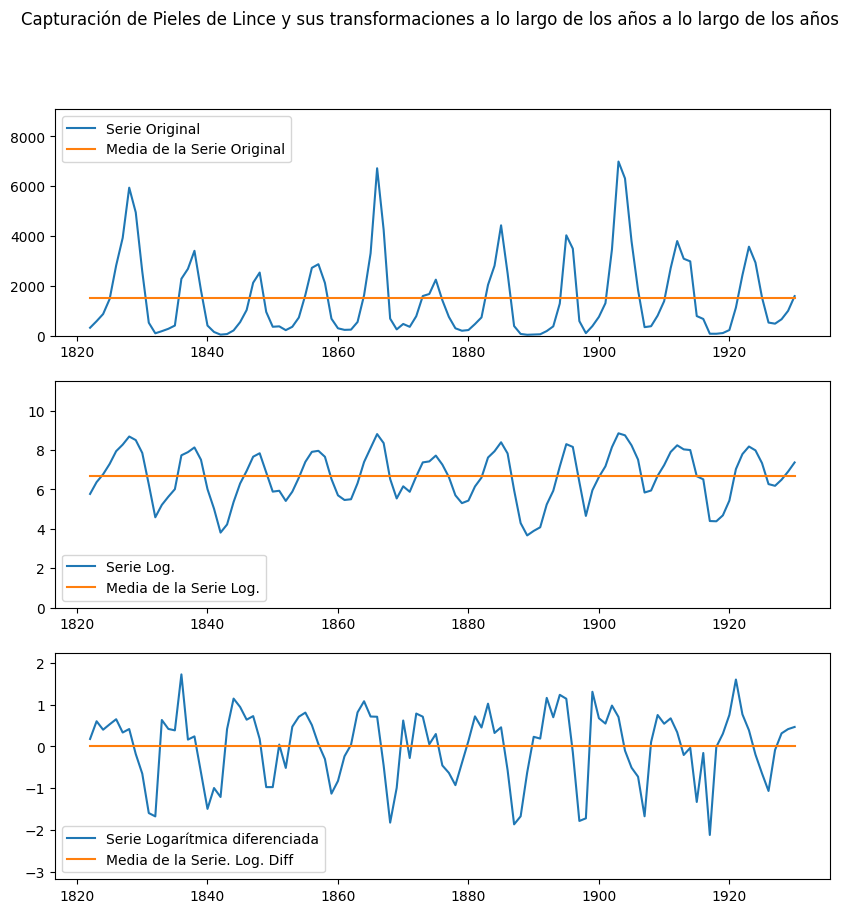

In [5]:
# separar x y la y para el gráfico
x = df.index

y = df["Pieles"]
y_media = [np.mean(y) for _ in y]

y_log = df["Pieles_log"]
y_log_media = [np.mean(y_log) for _ in y_log]

y_log_diff = df["Pieles_log_diff"]
y_log_diff_mean = [np.mean(y_log_diff) for _ in y_log_diff]

# visualización de los datos anteriores a los largo de los años
fig = plt.figure(figsize = (10, 10))
ax1, ax2, ax3 = fig.subplots(3, 1)

# la serie original parece ser no estacionaria
# si nos fijamos en su comportamiento, vemos muchos picos y que la media de diferentes
# tramos de la serie es diferente.
# además la covarianza entre diferentes tramos también parece distinta.
ax1.plot(x, y, label = "Serie Original")
ax1.plot(x, y_media, label = "Media de la Serie Original")
ax1.set_ylim(0, np.max(y)*1.3)
ax1.legend(loc = "upper left")

# Si transformamos la serie utilizando el logaritmo neperiano (ln)
# tenemos una serie que YA es estacionaria en media y que oscila entorno
# a 7.
ax2.plot(x, y_log, label = "Serie Log.")
ax2.plot(x, y_log_media, label = "Media de la Serie Log.")
ax2.set_ylim(0, np.max(y_log)*1.3)
ax2.legend(loc = "lower left")

# Si aplicamos una diferenciación a al serie logarítmica, seguimos teniendo
# una serie estacionaria, pero esta vez, la media de la serie oscila entorno al cero.

# La diferenciación de una serie estacionaria SIEMPRE da lugar a otra serie estacionaria.
# Por este motivo, no haría falta hacer la diferencia y con la serie transformada (logarítmica)
# es suficiente.

ax3.plot(x, y_log_diff, label = "Serie Logarítmica diferenciada")
ax3.plot(x, y_log_diff_mean, label = "Media de la Serie. Log. Diff")
ax3.set_ylim(np.min(y_log_diff)*1.5, np.max(y_log_diff)*1.3)
ax3.legend(loc = "lower left")

fig.suptitle("Capturación de Pieles de Lince y sus transformaciones a lo largo de los años a lo largo de los años");

**Comprobación de la estacionaridad de la serie**

In [6]:
for serie, nombre_serie in zip([y, y_log, y_log_diff], ["Serie Original", "Serie Log.", "Serie. Log. Diff"]):
    
    print("------------------------------------------------------------------")
    
    print("Estamos trabajando con la serie {}\n".format(nombre_serie))
    resultado_analisis = adfuller(serie)
    
    valor_estadistico_adf = resultado_analisis[0]
    p_valor = resultado_analisis[1]
    
    print("Valor estadistico de ADF de las tablas precalculadas: {}".format(-2.89))
    print("Valor estadistico de ADF: {}\n".format(valor_estadistico_adf))
    
    print("Nivel de significación para tomar la serie como estacionaria {}".format(0.05))
    print("p-valor: {}\n".format(p_valor))
    

------------------------------------------------------------------
Estamos trabajando con la serie Serie Original

Valor estadistico de ADF de las tablas precalculadas: -2.89
Valor estadistico de ADF: -3.079347373651806

Nivel de significación para tomar la serie como estacionaria 0.05
p-valor: 0.028119810051869233

------------------------------------------------------------------
Estamos trabajando con la serie Serie Log.

Valor estadistico de ADF de las tablas precalculadas: -2.89
Valor estadistico de ADF: -3.6493560033056376

Nivel de significación para tomar la serie como estacionaria 0.05
p-valor: 0.0048846046639502766

------------------------------------------------------------------
Estamos trabajando con la serie Serie. Log. Diff

Valor estadistico de ADF de las tablas precalculadas: -2.89
Valor estadistico de ADF: -3.679978100551146

Nivel de significación para tomar la serie como estacionaria 0.05
p-valor: 0.0044037584120516105



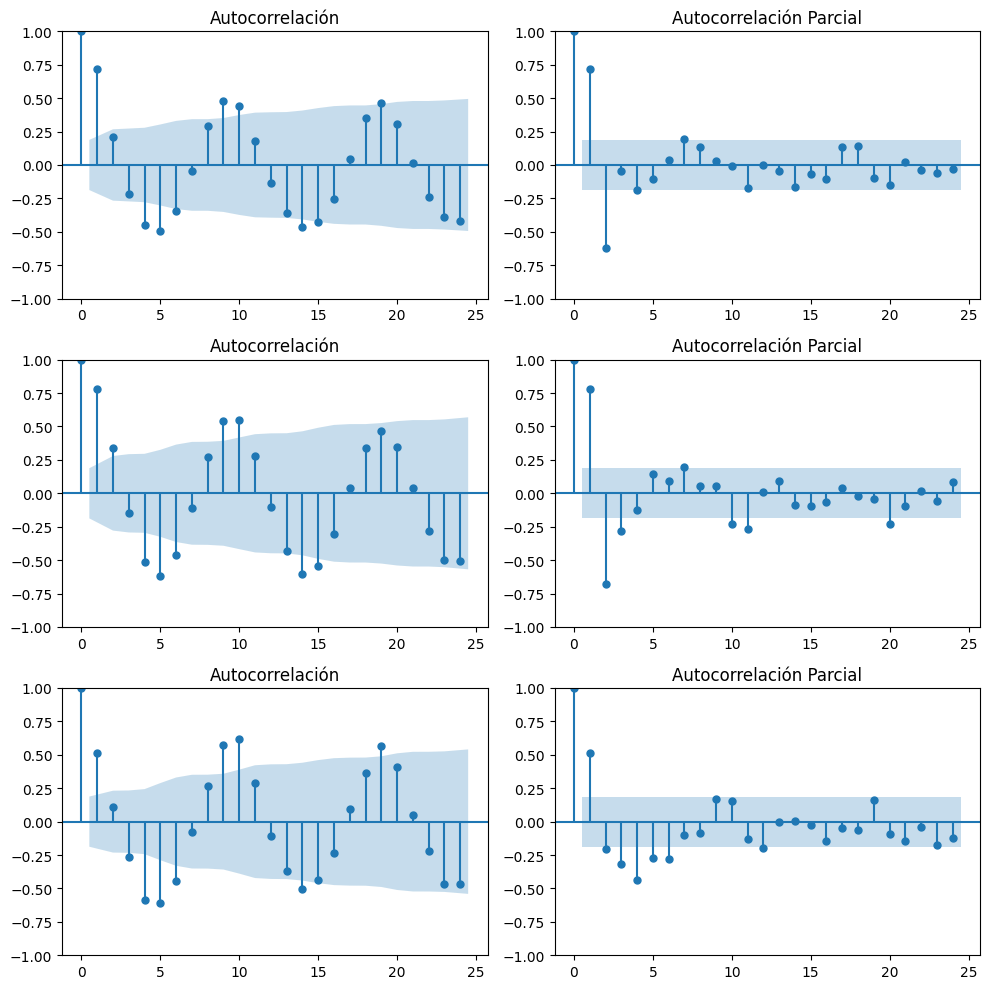

In [7]:
LAGS = 24

fig = plt.figure(figsize = (10, 10))

((ax1, ax2), (ax3, ax4), (ax5, ax6)) = fig.subplots(3, 2)

# ----------------------------------------------------------------------------------------------------
# plot the data using the built in plots from the stats module
plot_acf(y, ax = ax1, lags = LAGS, title = "Autocorrelación")
plot_pacf(y, ax = ax2, lags = LAGS, title = "Autocorrelación Parcial")

plot_acf(y_log, ax = ax3, lags = LAGS, title = "Autocorrelación")
plot_pacf(y_log, ax = ax4, lags = LAGS, title = "Autocorrelación Parcial")

plot_acf(y_log_diff, ax = ax5, lags = LAGS, title = "Autocorrelación")
plot_pacf(y_log_diff, ax = ax6, lags = LAGS, title = "Autocorrelación Parcial")

fig.tight_layout()

Si nos fijamos en los gráficos que obtenemos, vemos que hay para la serie y_log, el gráfico de autocorrelación parcial (segunda fila a la derecha) tiene 3 valores por encima del área sombreada por tanto estos valores son significativamente distintos de cero. Podemos suponer analizando esta serie que el proceso estocástico que ha generado la serie es un AR(3).

Ahora bien, también si analizamos conjuntamente con el ACF (gráficos a la izquierda) vemos que el 3 valor es próximo a área sombreada y por tanto, podemos sugerir otro proceso que haya podido generar este serie como un ARMA(2, 1).

Tal y como sugiere la metodología Box - Jenkins: en la fase de análisis de los ACF y PACF, tenemos que "acotar" los posibles modelos que hayan podido generar la serie siempre optando por el más sencillo de todos.

En la fase de identificación y estimación de paramétros, también podemos calcular el parámetro δ (delta) que vendría a ser la constante del modelo o la media.

**Separación Train y Test**

In [8]:
serie_a_predecir = y_log

In [9]:
y_index = serie_a_predecir.index

date_train = int(len(y_index)*0.9)

y_train = serie_a_predecir[y_index[:date_train]]
y_test = serie_a_predecir[y_index[date_train:len(y_index)]]

In [10]:
y_train.tail()

Año
1915-01-01    6.672033
1916-01-01    6.513230
1917-01-01    4.394449
1918-01-01    4.382027
1919-01-01    4.682131
Name: Pieles_log, dtype: float64

In [11]:
y_test.head()

Año
1920-01-01    5.433722
1921-01-01    7.031741
1922-01-01    7.796469
1923-01-01    8.181441
1924-01-01    7.984463
Name: Pieles_log, dtype: float64

**Gridsearch: la búsqueda de los parámetros óptimos para el modelo ARIMA**

In [12]:
# Para hacer el gridsearch, vamos a calcular los posibles valores que vamos a pasarle al modelo.
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

# Vamos a utilizar el modelo SARIMAX, porque en su implementaciòn en Python existen herramientas adicionales
# que nos facilitan el análisis y que no están disponibles en la implementación de ARIMA.

# Ahora bien, SARIMAX es un modelo ARIMA pero con un componente estacional (la leta S de Seasonal) y también
# un componente exógeno (X de eXogenous regressors)
# Por tanto un modelo SARIMAX de (1, 1, 1) x (0, 0, 0, 0)
# Es un modelo ARIMA (1, 1, 1)

# En caso de querer probar un modelo SARIMAX completo, ejecutar la siguiente línea de itertools.
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# Los dejamos a cero para sólo analizar un modelo ARIMA.
seasonal_pdq = [(0, 0, 0, 0)]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[0]))
print('SARIMAX: {} x {}'.format(pdq[3], seasonal_pdq[0]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 0, 0)
SARIMAX: (0, 1, 0) x (0, 0, 0, 0)


Como hemos visto en la sesión teórica, un modelo ARIMA se repsenta como ARIMA (p, d, q) donde:

AR (p): representa la parte "Autorregresiva" del modelo. La intuición básica consiste en que los valores pasados más próximos al momento "t", tendrán mayor impacto en los valores presentes. Para determinar el orden "p" del modelo, podemos utilizar el plot de autocorrelación parcial

I (d): representa la parte "Integral" del modelo y este parámetro del modelo nos dice cuantos diferenciaciones (restas de la serie contra si misma) se tienen que llevar a cabo para convertir la serie en estacionaria.

MA (q): representa la parte de "Medias Móviles". Como vimos, esto implica que el error del modelo se establece como una combinaciòn lineal de los errores observados en el pasado. Para determinar el orden "q" del modelo, podemos utilizar el plot de autocorrelación.

El modelo básico de ARIMA se puede extender más alla incorporando la estacionalidad de la serie y variables exógenas. En este caso estaríamos hablado del modelo SARIMAX representado por (p, d, q) x (P, D, Q) S: donde los parámetros (P, D, Q) representan la misma idea que los (p, d, q) pero tratan sobre la parte estacional de la serie.

El parámetro S a su vez representa el número de periodos que tienen que pasar para que la estacionalidad se repita: 12 para meses, 4 para trimestres etc.

A continuación utilizaremos una "Gridsearch" básico para buscar los parámetros óptimos del modelo ARIMA.

In [13]:
st = time.time()

best_score = 0
best_params = None
best_seasonal_params = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            
            mod = sm.tsa.statespace.SARIMAX(y_train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity = False,
                                            enforce_invertibility = False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            # guardamos el mejor resultado
            if best_score == 0:
                best_score = results.aic
                best_params = param
                best_seasonal_params = param_seasonal
                
            elif abs(results.aic) < abs(best_score):
                best_score = results.aic
                best_params = param
                best_seasonal_params = param_seasonal
            
        # alguna combinación de parámetros en SARIMAX, no son válidos
        # y los vamos a cazar con un except
        except:
            continue

et = time.time()

print("La búsqueda de parámetros no ha llevado {} minutos!".format((et - st)/60))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.29895D+00    |proj g|=  4.11813D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   5.080D-08   3.299D+00
  F =   3.2989435794374078     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(0, 0, 0, 0)12 - AIC:648.5929415697319
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(0, 0, 2)x(0, 0, 0, 0)12 - AIC:427.8859508702665
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24205D+00    |proj g|=  1.79884D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3      5      1     0     0   5.150D-06   1.242D+00
  F =   1.2419901679673997     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(0, 0, 0, 0)12 - AIC:245.43007292161033
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =      

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19811D+00    |proj g|=  1.27079D-01

At iterate    5    f=  1.10995D+00    |proj g|=  9.94761D-02

At iterate   10    f=  1.10619D+00    |proj g|=  2.13989D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     18      1     0     0   2.140D-06   1.106D+00
  F =   1.1061941272232676     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 2, 2)x(0, 0, 0, 0)12 - AIC:222.81404893576047
RUNNING THE L-B

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     15      1     0     0   3.118D-04   1.250D+00
  F =   1.2496429929890389     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 0)x(0, 0, 0, 0)12 - AIC:248.93002662585164
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11576D+00    |proj g|=  1.80618D-01

At iterate    5    f=  1.10650D+00    |proj g|=  5.39042D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1      9      1     0     0   1.756D-05   1.104D+00
  F =   1.1036439865672516     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 0)x(0, 0, 0, 0)12 - AIC:220.31422136718132
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08848D+00    |proj g|=  3.63007D-02

At iterate    5    f=  1.08741D+00    |proj g|=  5.71389D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  1.04252D+00    |proj g|=  6.81684D-02

At iterate   30    f=  1.04209D+00    |proj g|=  1.65204D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     50      1     0     0   1.652D-03   1.042D+00
  F =   1.0420920033298497     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 2)x(0, 0, 0, 0)12 - AIC:214.25003265265056
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.07861D+00    |proj g|=  1.82981D-05

           * *

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.84630D-01    |proj g|=  8.02618D-02

At iterate   10    f=  8.66475D-01    |proj g|=  1.42146D-01

At iterate   15    f=  8.62362D-01    |proj g|=  5.14308D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     24      1     0     0   2.094D-06   8.624D-01
  F =  0.86236013556470670     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 2)x(0, 0, 0, 0)12 - AIC:179.0225865706825
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57640D+00    |proj g|=  3.07653D-01

At iterate    5    f=  1.13170D+00    |proj g|=  3.19363D-01

At iterate   10    f=  1.09724D+00    |proj g|=  4.15305D-03

At iterate   15    f=  1.09668D+00    |proj g|=  1.45705D-02

At iterate   20    f=  9.84890D-01    |proj g|=  1.96116D+00

At iterate   25    f=  9.44732D-01    |proj g|=  1.22550D-01

At iterate   30    f=  9.44165D-01    |proj g|=  1.48016D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


El índice de AIC es Akaike Information Criterion y sirve para elegir un modelo entre un conjunto de posibles modelos.

El índice calcula la distancia de Kullback - Leibler entre el modelo y la serie.

Una forma de interpretar el índice es: buscamos el modelo con el menor índice porque este es el más simple que se ajusta a los datos.

In [14]:
print("El mejor modelo es {}, \nCon un AIC de {}".format(best_params, best_score))


El mejor modelo es (2, 1, 2), 
Con un AIC de 179.0225865706825


In [16]:
# Entrenamos el modelo con los mejores parametros.

mod = sm.tsa.statespace.SARIMAX(y_train,
                                order = best_params,
                                seasonal_order = param_seasonal,
                                enforce_stationarity = False,
                                enforce_invertibility = False)

results = mod.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02147D+00    |proj g|=  5.75822D-01

At iterate    5    f=  8.84630D-01    |proj g|=  8.02618D-02

At iterate   10    f=  8.66475D-01    |proj g|=  1.42146D-01

At iterate   15    f=  8.62362D-01    |proj g|=  5.14308D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     24      1     0     0   2.094D-06   8.624D-01
  F =  0.86236013556470670     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


**Interpretación del mejor modelo**

In [17]:
results = mod.fit()

print(results.summary().tables[1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02147D+00    |proj g|=  5.75822D-01

At iterate    5    f=  8.84630D-01    |proj g|=  8.02618D-02

At iterate   10    f=  8.66475D-01    |proj g|=  1.42146D-01

At iterate   15    f=  8.62362D-01    |proj g|=  5.14308D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     24      1     0     0   2.094D-06   8.624D-01
  F =  0.86236013556470670     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
        

 This problem is unconstrained.


Vemos de la tabla de coeficientes, que a pesar de seleccionar el modelo con el mejor AIC, tenemos 3 parametros que no son significativos porque su p - valor es superior a 0.05.

Estamos hablando del ma.L1, ma.L2 y sigma2.

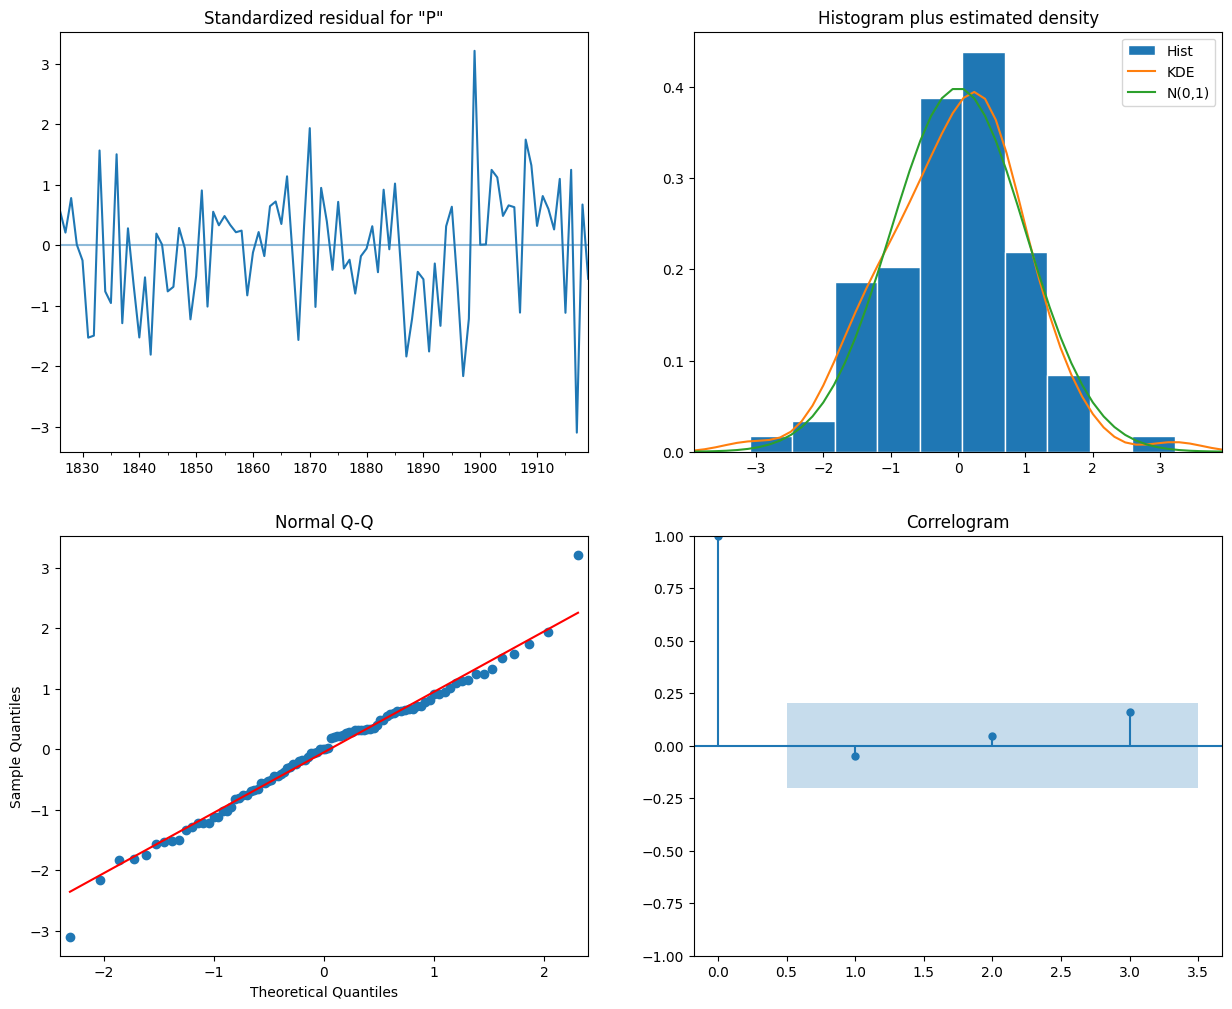

In [18]:
results.plot_diagnostics(figsize = (15, 12), lags = 3);

Interprentado los gráficos podemos observar lo siguiente:

Arriba a la izquiera: los residuos del modelo parece que siguen un proceso de Ruido Blanco (White Noise) y no son predecibles. Esto implica que nuestro modelo ha extraído toda la información de los datos.

Arriba a la derecha: vemos que la distribución de los residuos sigue una distribución próxima a la Normal (0, 1).

Abajo a la derecha: vemos que la autocorrelación parcial entre los residuos y residuos - k, dan lugar a valores no significativos.  Esto implica que no "nos queda" información a extraer de los residuos, es decir el modelo no ha sido capaz de reproducir el patrón de comportamiento sistemático de la serie y habría que reformularlo.

Abajo a la izquierda: la distrbución ordenada de los residuos sigue una Normal.

**Predicción utilizando el modelo**

In [19]:
# Para hacer una predicción es suficiente con especificar el número de steps/pasos futuros a estimar.
pred_uc = results.get_forecast(steps = len(y_test))

# Calcula el intervalo de confianza de la predicción.
pred_ci = pred_uc.conf_int()

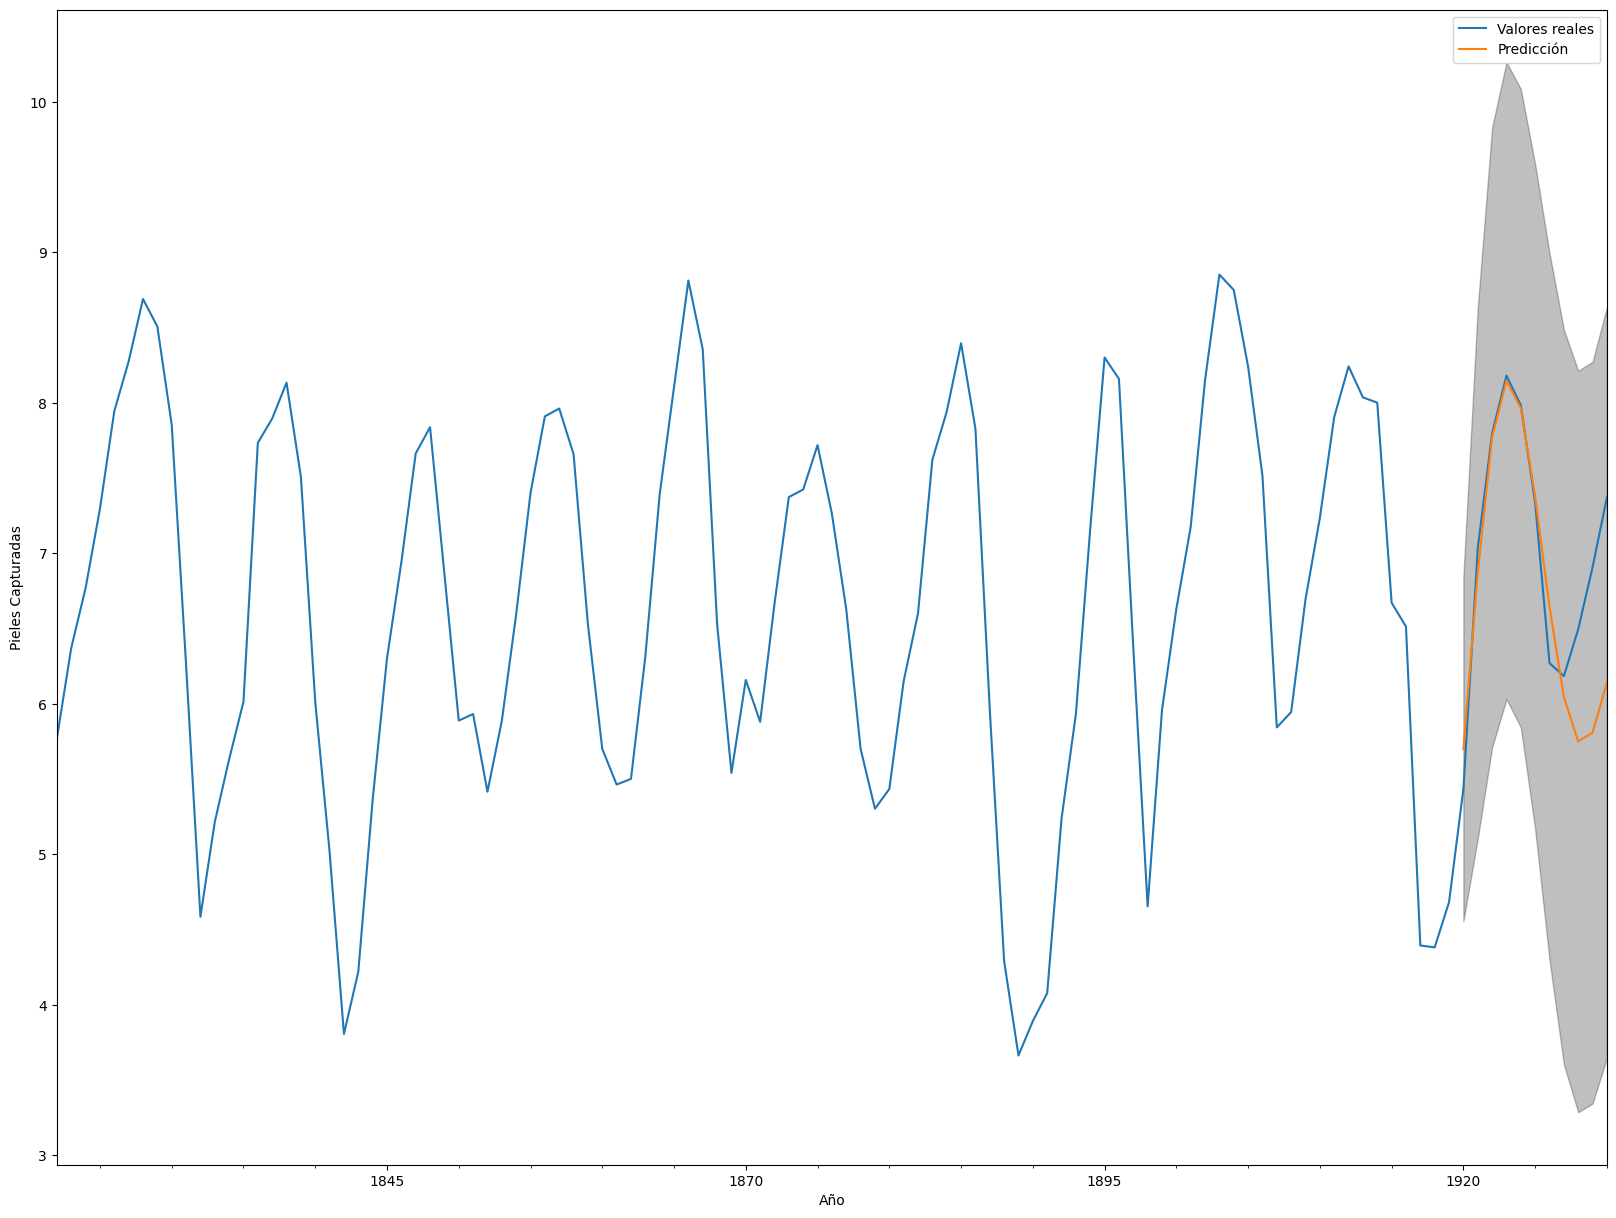

In [20]:
ax = serie_a_predecir.plot(label = 'Valores reales', figsize = (20, 15))

pred_uc.predicted_mean.plot(ax = ax, label = 'Predicción')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color = 'k', alpha = .25)

ax.set_xlabel('Año')
ax.set_ylabel('Pieles Capturadas')

plt.legend()
plt.show()

In [21]:
y_pred = pred_ci.iloc[:, 0]

In [22]:
# El RMSE es de 2.52
rmse = sqrt(metrics.mean_squared_error(y_test, y_pred))

print("El modelo ARIMA con los parametros {}, ha dado un rmse en test de {}".format(best_params, round(rmse, 2)))

El modelo ARIMA con los parametros (2, 1, 2), ha dado un rmse en test de 2.53
